In [1]:
#import modules
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# All imports you likely would need
## Models and modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

## Data Munging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

## Measurements
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay # for newer versions of sklearn
from sklearn.metrics import plot_confusion_matrix  # for older versions of sklearn
import matplotlib.pyplot as plt

In [2]:
# read data
df = pd.read_csv("startup data.csv", index_col=0)
df.head()

,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,founded_at,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,1/1/2007,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,1/1/2000,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,3/18/2009,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,1/1/2002,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,8/1/2010,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [3]:
df.isnull().sum()

state_code                    0
latitude                      0
longitude                     0
zip_code                      0
id                            0
city                          0
Unnamed: 6                  493
name                          0
labels                        0
founded_at                    0
closed_at                   588
first_funding_at              0
last_funding_at               0
age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year    152
age_last_milestone_year     152
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
state_code.1                  1
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
is_software                   0
is_web                        0
is_mobile                     0
is_enter

In [4]:
# data wrangling
df = df.drop(['Unnamed: 6'], axis=1)
df = df.drop(['state_code.1'], axis=1)
df = df.drop(['object_id'], axis=1)
start = ['c:']
end = ['']
df['id'] = df['id'].replace(start, end, regex=True)
df.avg_participants = df.avg_participants.round(4)
df['age_first_milestone_year'] = df['age_first_milestone_year'].fillna(0)
df['age_last_milestone_year'] = df['age_last_milestone_year'].fillna(0)

In [5]:
# determine age of startup
df['closed_at'] = pd.to_datetime(df['closed_at'])
df['founded_at'] = pd.to_datetime(df['founded_at'])

# too many NaN in age
df["age"] = (df["closed_at"]-df["founded_at"])
df["age"]=round(df.age/np.timedelta64(1,'Y'))


In [6]:
# variable modification
df['status'] = df.status.map({'acquired':1, 'closed':0})
df['status'].astype(int)

#has rounds of funding
df['has_rounds'] = np.where((df['has_roundA'] == 1) | (df['has_roundB'] == 1) | (df['has_roundC'] == 1) | (df['has_roundD'] == 1), 1, 0)

#has investor
df['has_investor'] = np.where((df['has_VC'] == 1) | (df['has_angel'] == 1), 1, 0)

In [7]:
# probability analysis
""" goal: narrow down a few factors that show statistically significant results
--> later, we will use them as parameters for machine learning model"""

' goal: narrow down a few factors that show statistically significant results\n--> later, we will use them as parameters for machine learning model'

In [8]:
# visualizations
""" goal: explore startup success by different key factors:
--> location
--> funding amount
--> industry
--> age"""

' goal: explore startup success by different key factors:\n--> location\n--> funding amount\n--> industry\n--> age'

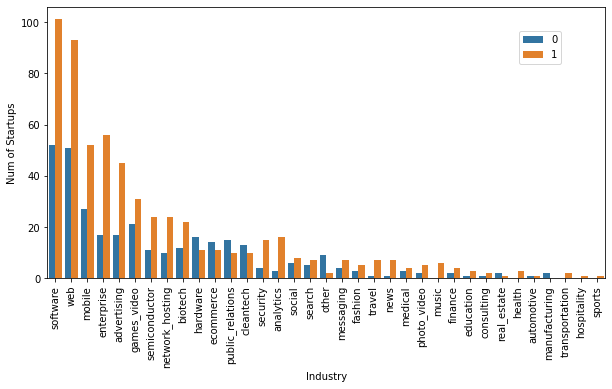

In [9]:
# success by industry
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x="category_code", hue="status", data=df,
              order=df.category_code.value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(xlabel="Industry", ylabel="Num of Startups")
plt.legend(bbox_to_anchor=(0.93, 0.93))

In [10]:
# success by location per industry
loc_industry_success = df.groupby(['state_code','category_code']).size().rename('total_startups').reset_index()
loc_industry_success = loc_industry_success[loc_industry_success.groupby('state_code')['total_startups'].transform(max) == loc_industry_success['total_startups']]
loc_industry_success = loc_industry_success.sort_values('total_startups', ascending=False)
loc_industry_success.head(10)

,state_code,category_code,total_startups
35,CA,web,80
99,MA,software,24
154,NY,web,21
199,TX,software,8
224,WA,web,7
222,WA,software,7
76,IL,software,5
46,CO,software,4
208,VA,web,4
204,VA,mobile,4


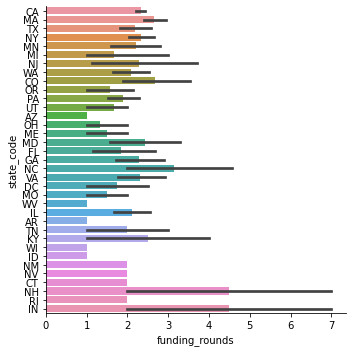

In [11]:
# funding rounds by location
rounds_df = df.sort_values(by=["funding_rounds"], ascending=True)
sns.catplot(data=rounds_df, y="state_code", x="funding_rounds", kind="bar")

In [12]:
# funding amounts by location
loc_funding_amt = df.groupby(['state_code','funding_total_usd']).size().rename('total_startups').reset_index()
loc_funding_amt = loc_funding_amt[loc_funding_amt.groupby('state_code')['total_startups'].transform(max) == loc_funding_amt['total_startups']]
loc_funding_amt = loc_funding_amt.sort_values('funding_total_usd', ascending=False)
loc_funding_amt.head(10)

,state_code,funding_total_usd,total_startups
332,CO,510000000,1
378,IN,238209999,1
479,NC,162264126,1
336,CT,125000000,1
460,MD,100000000,1
488,NJ,78500000,1
610,PA,75000000,1
609,PA,69900000,1
331,CO,68400000,1
357,GA,60704370,1


In [13]:
# funding amounts by industry
cat_funding_amt = df.groupby(['category_code','funding_total_usd']).size().rename('total_startups').reset_index()
cat_funding_amt = cat_funding_amt[cat_funding_amt.groupby('category_code')['total_startups'].transform(max) == cat_funding_amt['total_startups']]
cat_funding_amt = cat_funding_amt.sort_values('total_startups', ascending=False)
cat_funding_amt.head(10)

,category_code,funding_total_usd,total_startups
742,web,4000000,7
610,software,10000000,7
109,cleantech,5000000,3
527,semiconductor,10000000,3
434,network_hosting,30000000,3
8,advertising,2000000,3
362,mobile,5000000,3
358,mobile,4000000,3
172,enterprise,3500000,3
5,advertising,1000000,3


<AxesSubplot:xlabel='has_investor', ylabel='avg_participants'>

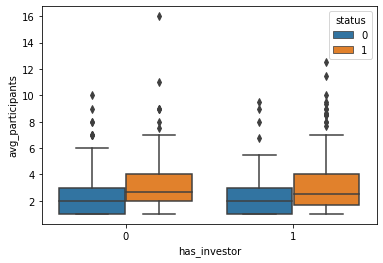

In [14]:
# average participants
sns.boxplot(x = "has_investor", y = "avg_participants", 
            data = df, hue = "status")

<AxesSubplot:xlabel='milestones', ylabel='Count'>

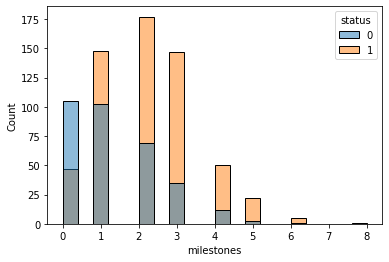

In [15]:
# milestones
sns.histplot(x = "milestones", data = df, hue="status")

<AxesSubplot:xlabel='age', ylabel='relationships'>

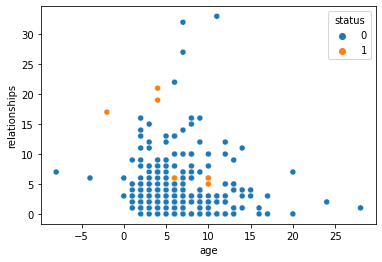

In [16]:
# relationships
sns.scatterplot(data=df, x='age', y='relationships', hue='status')

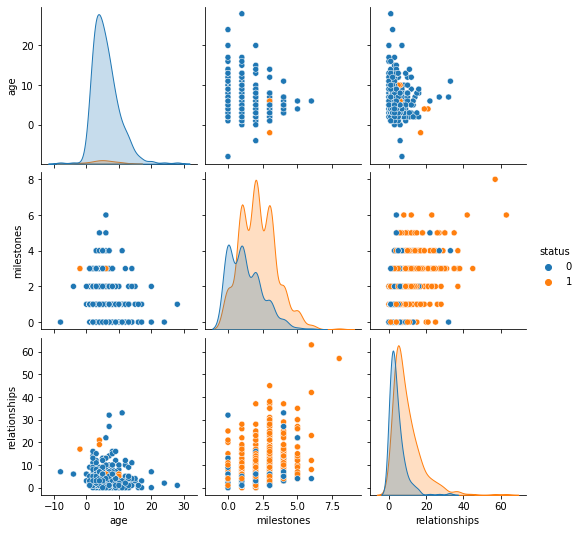

In [17]:
# pair plot - can use to show lack of correlation
pair_data = df[['age','milestones','relationships', 'status']]
sns.pairplot(pair_data, hue="status")

<AxesSubplot:>

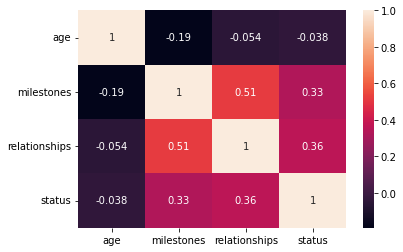

In [18]:
# more correlational data
heatmap_data = df[['age', 'milestones','relationships','status']]
sns.heatmap(heatmap_data.corr(), annot=True)

<AxesSubplot:>

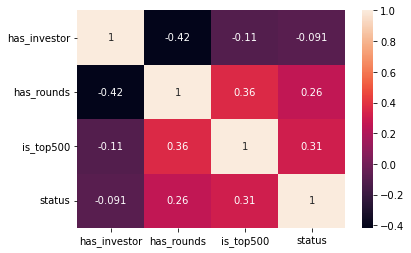

In [19]:
# binary vars heatmap
heatmap_data2 = df[['has_investor', 'has_rounds','is_top500','status']]
sns.heatmap(heatmap_data2.corr(), annot=True)

In [20]:
# machine learning model
""" goal: use top 3-4 factors from prob & visualization analysis
--> create a machine learning model to predict startup success"""

' goal: use top 3-4 factors from prob & visualization analysis\n--> create a machine learning model to predict startup success'

best n: 13


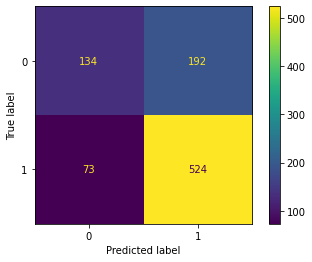

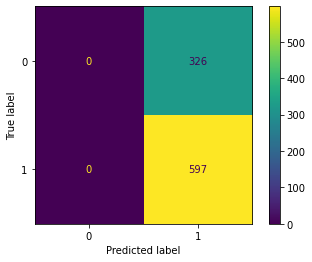

In [21]:
df_ml = df[['status', 'funding_total_usd', 'milestones', 'category_code']]
col_target = 'status'

target = df_ml[col_target].values
categorical = OneHotEncoder().fit_transform(df_ml[['category_code']].values).toarray()
data = np.append(categorical, df_ml[['funding_total_usd', 'milestones']].values, axis=1)

train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=216)

params_to_try = {'n_neighbors': range(1, 20)}
knn_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params_to_try)
knn_search.fit(train_data, train_target)

baseline_model = DummyClassifier(strategy="most_frequent")
baseline_model.fit(X=train_data, y=train_target)
baseline_predicted = baseline_model.predict(data)

accuracy_model = knn_search.score(test_data, test_target)
accuracy_baseline = accuracy_score(y_true=target, y_pred=baseline_predicted)
print('best n:', knn_search.best_params_['n_neighbors'])

ConfusionMatrixDisplay.from_estimator(estimator=knn_search, X=data, y=target)
plt.grid(False)
ConfusionMatrixDisplay.from_estimator(estimator=baseline_model, X=data, y=target)
plt.grid(False)


In [22]:
print(df_ml.shape)
print('>=300 rows?', df_ml.shape[0] >= 300)
print('Categories:')
print(df_ml[col_target].value_counts())
print('Accuracy: ', accuracy_model)
print('Accuracy Baseline: ', accuracy_baseline)

(923, 4)
>=300 rows? True
Categories:
1    597
0    326
Name: status, dtype: int64
Accuracy:  0.7081081081081081
Accuracy Baseline:  0.6468039003250271
